<a href="https://colab.research.google.com/github/vixbi/actprobl/blob/main/Shumakova_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# импорт библиотек

import os
os.environ["KERAS_BACKEND"] = "torch"
import gc

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import keras
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

from tqdm.auto import tqdm
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score

# Подготовка датасета

In [ ]:
data = pd.read_csv("lenta_sample.csv")

texts = data.text.values
id2label = {i:l for i,l in enumerate(set(data.topic))}
label2id = {l:i for i,l in id2label.items()}
targets = [label2id[l] for l in data.topic]

train_texts, valid_texts, train_targets, valid_targets = train_test_split(texts, targets, test_size=0.05)

# Общие классы и функции для моделей

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, tokenizer, MAX_LEN, texts, targets):

        self.tokenizer = tokenizer
        self.texts = [torch.LongTensor(tokenizer.encode(t)[:MAX_LEN]) for t in texts]
        self.texts = torch.nn.utils.rnn.pad_sequence(self.texts, batch_first=True,
                                                     padding_value=self.tokenizer.pad_token_id)

        self.MAX_LEN = MAX_LEN
        self.length = len(texts)

        self.target = torch.LongTensor(targets)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        ids = self.texts[index]
        y = self.target[index]

        return ids, y

    def preprocess(self, text):
        tokens = text.lower().split()
        tokens = [token.strip(punctuation) for token in tokens]
        tokens = [token for token in tokens if token]
        return tokens

In [ ]:
# функции для обучения
def train(model, iterator, optimizer, criterion, print_every=1000):

    epoch_loss = []
    epoch_f1 = []

    model.train()

    for i, (texts, ys) in enumerate(iterator):

        optimizer.zero_grad()
        predictions = model(texts.to(device)).squeeze()
        loss = criterion(predictions, ys.to(device))



        loss.backward()
        optimizer.step()
        preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
        y_true = ys.tolist()

        epoch_loss.append(loss.item())
        epoch_f1.append(f1_score(y_true, preds, average="micro"))

        if not (i+1) % print_every:
            print(f'Loss: {np.mean(epoch_loss)}; F1 measure: {np.mean(epoch_f1)}')

    return np.mean(epoch_f1)

def evaluate(model, iterator, criterion):

    epoch_loss = []
    epoch_f1 = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:

            predictions = model(texts.to(device)).squeeze()
            loss = criterion(predictions, ys.to(device))
            preds = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            y_true = ys.tolist()


            epoch_loss.append(loss.item())
            epoch_f1.append(f1_score(y_true, preds, average="micro"))

    return np.mean(epoch_f1)# / len(iterator)

def predict(model, iterator):

    preds = []

    model.eval()
    with torch.no_grad():
        for texts, ys in iterator:
            predictions = model(texts.to(device)).squeeze()
            ys = predictions.detach().to('cpu').numpy().argmax(1).tolist()
            preds.extend(ys)

    return preds

In [ ]:
class CLF(nn.Module):

    def __init__(self, pretrained_model, num_classes, avg_pool=False):
        super().__init__()
        self.tokenizer = tokenizer # токенизатор
        self.pretrained_model = pretrained_model # предобученная модель
        self.drop = nn.Dropout(0.3) # добавим дропаут чтобы не переобучалось
        self.fc = nn.Linear(768, num_classes)
        self.act = nn.LogSoftmax(1)
        self.avg_pool = False

    def forward(self, texts):

        mask = (texts != tokenizer.pad_token_id).long()

        # прогоняем через BERT
        hidden = self.pretrained_model(texts, attention_mask=mask)[0]

        if self.avg_pool == False:
            # берем самое первое состояние и применяем к нему линейный слой и активацию
            to_drop = hidden[:,0]
        elif self.avg_pool == True:
            to_drop = hidden.mean(1)

        outputs=self.act(self.fc(self.drop(to_drop)))

        return outputs

# Дообучение modernbert-base целиком

## Подготовка

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.03125
1
Eval -  0.0
2
Eval -  0.0625
3
Eval -  0.03125
4
Eval -  0.20089285714285715
5
Eval -  0.09375
6
Eval -  0.1607142857142857
7
Eval -  0.125
8
Eval -  0.03125
9
Eval -  0.10267857142857142
10
Eval -  0.1919642857142857
11
Eval -  0.16964285714285715
12
Eval -  0.0625
13
Eval -  0.22767857142857142
14
Eval -  0.1294642857142857
15
Eval -  0.1607142857142857
16
Eval -  0.09821428571428571
17
Eval -  0.09821428571428571
18
Eval -  0.1919642857142857
19
Eval -  0.22767857142857142
20
Eval -  0.1294642857142857
21
Eval -  0.16964285714285715
22
Eval -  0.09375
23
Eval -  0.16517857142857142
24
Eval -  0.13392857142857142
25
Eval -  0.1607142857142857
26
Eval -  0.125
27
Eval -  0.1919642857142857
28
Eval -  0.13392857142857142
29
Eval -  0.1607142857142857


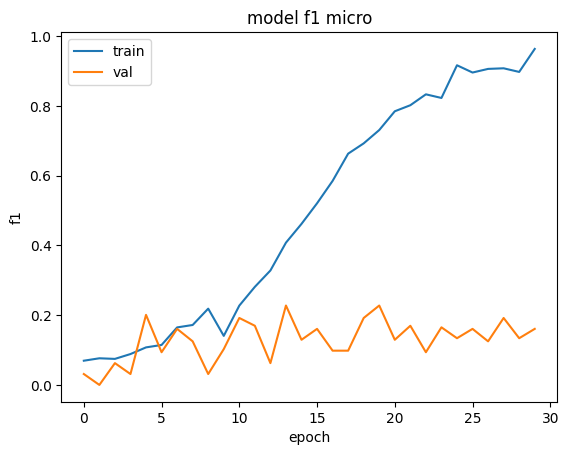

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         3
           2       0.00      0.00      0.00         5
           3       0.17      1.00      0.29         1
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         1
           9       1.00      1.00      1.00         1
          10       0.33      0.33      0.33         3
          12       0.50      1.00      0.67         1
          13       0.00      0.00      0.00         2
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3

    accuracy                           0.16        31
   macro avg       0.19   

# Дообучение rumodernbert-base

## Подготовка

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(30):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.10267857142857142
1
Eval -  0.1607142857142857
2
Eval -  0.3169642857142857
3
Eval -  0.28125
4
Eval -  0.4464285714285714
5
Eval -  0.42410714285714285
6
Eval -  0.4285714285714286
7
Eval -  0.41964285714285715
8
Eval -  0.45089285714285715
9
Eval -  0.4375
10
Eval -  0.4464285714285714
11
Eval -  0.42410714285714285
12
Eval -  0.4598214285714286
13
Eval -  0.4151785714285714
14
Eval -  0.45535714285714285
15
Eval -  0.45535714285714285
16
Eval -  0.4464285714285714
17
Eval -  0.45535714285714285
18
Eval -  0.4464285714285714
19
Eval -  0.4419642857142857
20
Eval -  0.45535714285714285
21
Eval -  0.45089285714285715
22
Eval -  0.4464285714285714
23
Eval -  0.45089285714285715
24
Eval -  0.45535714285714285
25
Eval -  0.45535714285714285
26
Eval -  0.45535714285714285
27
Eval -  0.4642857142857143
28
Eval -  0.4464285714285714
29
Eval -  0.45535714285714285


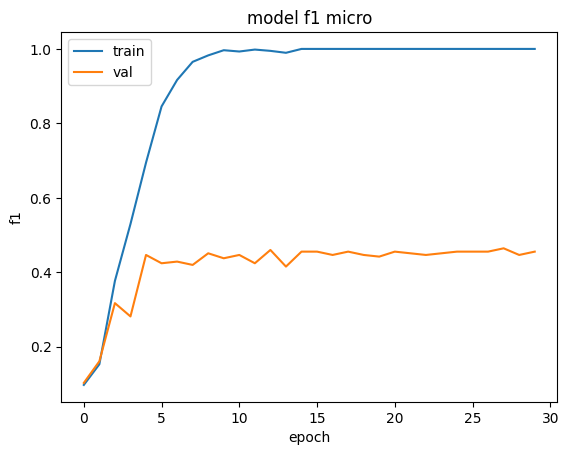

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.50      0.33      0.40         3
           2       0.29      0.40      0.33         5
           3       0.00      0.00      0.00         1
           4       1.00      0.50      0.67         2
           5       1.00      0.33      0.50         3
           7       0.00      0.00      0.00         2
           8       0.50      1.00      0.67         1
           9       0.20      1.00      0.33         1
          10       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       0.67      1.00      0.80         2
          15       0.50      0.25      0.33         4
          16       0.00      0.00      0.00         3

    accuracy                           0.45        31
   macro avg       0.48      0.49      0.43        31
weighted avg       0.51      0.45      0.44        31



# Дообучение modernbert-base с заморозкой

## Подготовка

In [ ]:
model_id = "answerdotai/ModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

for param in model_modernbert.parameters():
    param.requires_grad = False

model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.0
1
Eval -  0.0
2
Eval -  0.0
3
Eval -  0.1294642857142857
4
Eval -  0.2857142857142857
5
Eval -  0.2232142857142857
6
Eval -  0.09821428571428571
7
Eval -  0.22767857142857142
8
Eval -  0.16517857142857142
9
Eval -  0.19642857142857142
10
Eval -  0.16517857142857142
11
Eval -  0.2544642857142857
12
Eval -  0.3214285714285714
13
Eval -  0.1294642857142857
14
Eval -  0.2232142857142857
15
Eval -  0.20089285714285715
16
Eval -  0.16517857142857142
17
Eval -  0.26339285714285715
18
Eval -  0.22767857142857142
19
Eval -  0.25
20
Eval -  0.2232142857142857
21
Eval -  0.26339285714285715
22
Eval -  0.2857142857142857
23
Eval -  0.22767857142857142
24
Eval -  0.2857142857142857
25
Eval -  0.2857142857142857
26
Eval -  0.3169642857142857
27
Eval -  0.3169642857142857
28
Eval -  0.32589285714285715
29
Eval -  0.33035714285714285
30
Eval -  0.3214285714285714
31
Eval -  0.3214285714285714
32
Eval -  0.3214285714285714
33
Eval -  0.3348214285714286
34
Eval -  0.3125
35
Eval -  0.3125


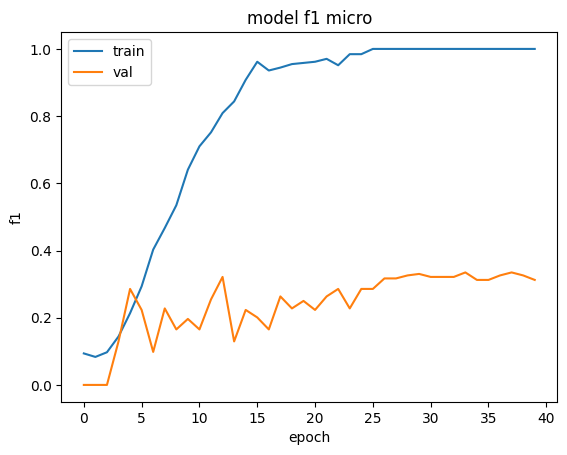

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

              precision    recall  f1-score   support

           1       1.00      0.33      0.50         3
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         2
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         0
           7       0.33      0.50      0.40         2
           8       0.00      0.00      0.00         1
           9       0.33      1.00      0.50         1
          10       0.67      0.67      0.67         3
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         1
          13       0.33      1.00      0.50         2
          14       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         4
          16       0.00      0.00      0.00         3

    accuracy                           0.32        31
   macro avg       0.29   

# Дообучение rumodernbert-base с заморозкой (cls)

## Подготовка

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)

for param in model_modernbert.parameters():
    param.requires_grad = False

model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id))
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.21875
1
Eval -  0.16517857142857142
2
Eval -  0.21875
3
Eval -  0.23214285714285715
4
Eval -  0.1875
5
Eval -  0.34375
6
Eval -  0.3125
7
Eval -  0.3214285714285714
8
Eval -  0.3482142857142857
9
Eval -  0.35714285714285715
10
Eval -  0.3526785714285714
11
Eval -  0.41964285714285715
12
Eval -  0.41964285714285715
13
Eval -  0.4151785714285714
14
Eval -  0.4151785714285714
15
Eval -  0.41964285714285715
16
Eval -  0.3973214285714286
17
Eval -  0.4464285714285714
18
Eval -  0.4107142857142857
19
Eval -  0.48660714285714285
20
Eval -  0.48660714285714285
21
Eval -  0.5133928571428571
22
Eval -  0.48214285714285715
23
Eval -  0.4732142857142857
24
Eval -  0.48214285714285715
25
Eval -  0.48214285714285715
26
Eval -  0.4910714285714286
27
Eval -  0.4776785714285714
28
Eval -  0.5133928571428571
29
Eval -  0.5223214285714286
30
Eval -  0.5133928571428571
31
Eval -  0.5267857142857143
32
Eval -  0.5178571428571428
33
Eval -  0.5178571428571428
34
Eval -  0.5178571428571428
35
Eva

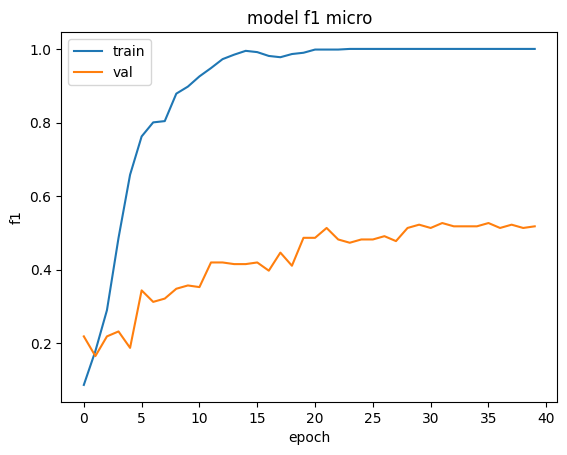

In [ ]:
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title('model f1 micro')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         3
           2       0.50      0.20      0.29         5
           3       0.00      0.00      0.00         1
           4       1.00      1.00      1.00         2
           5       1.00      0.33      0.50         3
           6       0.00      0.00      0.00         0
           7       0.25      0.50      0.33         2
           8       1.00      1.00      1.00         1
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         3
          11       0.00      0.00      0.00         0
          12       1.00      1.00      1.00         1
          13       0.67      1.00      0.80         2
          15       1.00      0.25      0.40         4
          16       0.33      0.67      0.44         3

    accuracy                           0.52        31
   macro avg       0.55      0.53      0.50        31
weighted avg       0.64   

# Дообучение rumodernbert-base с заморозкой (усредненный hidden_state)

## Подготовка

In [ ]:
model_id = "deepvk/RuModernBERT-base"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_modernbert = AutoModel.from_pretrained(model_id)
MAX_LEN = 512
training_set = Dataset(tokenizer, MAX_LEN, train_texts, train_targets)
training_generator = torch.utils.data.DataLoader(training_set, batch_size=8, shuffle=True, )
valid_set = Dataset(tokenizer, MAX_LEN, valid_texts, valid_targets)
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=8, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CLF(model_modernbert, len(label2id), avg_pool=True)
optimizer = optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.NLLLoss()
model = model.to(device)
criterion = criterion.to(device)

print("Percentage of trainable params:")
print('{0:.10f}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)/sum(p.numel() for p in model.parameters())))

Percentage of trainable params:
1.0000000000


## Обучение

In [ ]:
f1s = []
f1s_eval = []

for i in range(40):
    print(i)
    f1s.append(train(model, training_generator, optimizer, criterion, 2000))
    evl = evaluate(model, valid_generator, criterion)
    print('Eval - ', evl)
    f1s_eval.append(evl)

0
Eval -  0.0
1
Eval -  0.10267857142857142
2
Eval -  0.07142857142857142
3
Eval -  0.15625
4
Eval -  0.26339285714285715
5
Eval -  0.16964285714285715
6
Eval -  0.3794642857142857
7
Eval -  0.3214285714285714
8
Eval -  0.2857142857142857
9
Eval -  0.42410714285714285
10
Eval -  0.48214285714285715
11
Eval -  0.42410714285714285
12
Eval -  0.4776785714285714
13
Eval -  0.48214285714285715
14
Eval -  0.5491071428571428
15
Eval -  0.6116071428571428
16
Eval -  0.4151785714285714
17
Eval -  0.5491071428571428
18
Eval -  0.45089285714285715
19
Eval -  0.4151785714285714
20
Eval -  0.4151785714285714
21
Eval -  0.48214285714285715
22
Eval -  0.4910714285714286
23
Eval -  0.48660714285714285
24
Eval -  0.48660714285714285
25
Eval -  0.48660714285714285
26
Eval -  0.4910714285714286
27
Eval -  0.48214285714285715
28
Eval -  0.5178571428571428
29
Eval -  0.5133928571428571
30
Eval -  0.5491071428571428
31
Eval -  0.5535714285714286
32
Eval -  0.5758928571428571
33
Eval -  0.5758928571428571
34

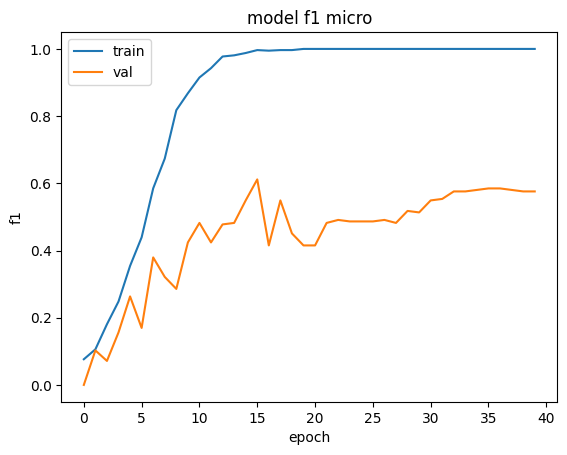

In [ ]:
# визуализация
plt.plot(f1s)
plt.plot(f1s_eval)
plt.title("model f1 micro")
plt.ylabel("f1")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [ ]:
valid_generator = torch.utils.data.DataLoader(valid_set, batch_size=16, shuffle=False)
preds = predict(model, valid_generator)
print(classification_report(valid_targets, preds))

model = None
gc.collect() # Python thing
torch.cuda.empty_cache() # PyTorch thing

/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/anton/cache/lada/transformers-venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         3
           2       0.50      0.40      0.44         5
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         2
           5       0.50      0.33      0.40         3
           7       0.25      0.50      0.33         2
           8       1.00      1.00      1.00         1
           9       0.50      1.00      0.67         1
          10       1.00      1.00      1.00         3
          12       1.00      1.00      1.00         1
          13       1.00      1.00      1.00         2
          15       1.00      0.25      0.40         4
          16       0.29      0.67      0.40         3

    accuracy                           0.58        31
   macro avg       0.65      0.65      0.62        31
weighted avg       0.64      0.58      0.57        31

